In [75]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_pickle('test_all_stats_no_dif.pkl')
print(data.shape)
data.tail(5)

(36822, 32)


k1    k2  Surface  hour  round  p1_win  \
date       player1     player2                                                 
2020-11-21 Medvedev D. Nadal R.     1.72  2.10      2.0    23   28.0       1   
           Nadal R.    Medvedev D.  2.10  1.72      2.0    23   28.0       0   
           Thiem D.    Djokovic N.  2.37  1.57      2.0    17   28.0       1   
2020-11-22 Medvedev D. Thiem D.     1.66  2.20      2.0    21   16.0       1   
           Thiem D.    Medvedev D.  2.20  1.66      2.0    21   16.0       0   

                                       p1_age     p2_age  p1_height  \
date       player1     player2                                        
2020-11-21 Medvedev D. Nadal R.     24.794521  34.493151       1.98   
           Nadal R.    Medvedev D.  34.493151  24.794521       1.85   
           Thiem D.    Djokovic N.  27.235616  33.526027       1.85   
2020-11-22 Medvedev D. Thiem D.     24.797260  27.238356       1.98   
           Thiem D.    Medvedev D.  27.238356  24.797260       1.85   

                                    p2_height  ...  \
date       player1     player2                 ...   
2020-11-21 Medvedev D. Nadal R.          1.85  ...   
           Nadal R.    Medvedev D.       1.98  ...   
           Thiem D.    Djokovic N.       1.88  ...   
2020-11-22 Medvedev D. Thiem D.          1.85  ...   
           Thiem D.    Medvedev D.       1.98  ...   

                                    second_serve_points_prc_match_common_player1  \
date       player1     player2                                                     
2020-11-21 Medvedev D. Nadal R.                                         0.526984   
           Nadal R.    Medvedev D.                                      0.590901   
           Thiem D.    Djokovic N.                                      0.531193   
2020-11-22 Medvedev D. Thiem D.                                         0.522934   
           Thiem D.    Medvedev D.                                      0.522412   

                                    second_serve_points_prc_match_common_player2  \
date       player1     player2                                                     
2020-11-21 Medvedev D. Nadal R.                                         0.590901   
           Nadal R.    Medvedev D.                                      0.526984   
           Thiem D.    Djokovic N.                                      0.555633   
2020-11-22 Medvedev D. Thiem D.                                         0.522412   
           Thiem D.    Medvedev D.                                      0.522934   

                                    winning_on_return_prc_common_player1  \
date       player1     player2                                             
2020-11-21 Medvedev D. Nadal R.                                 0.369188   
           Nadal R.    Medvedev D.                              0.402100   
           Thiem D.    Djokovic N.                              0.372535   
2020-11-22 Medvedev D. Thiem D.                                 0.368747   
           Thiem D.    Medvedev D.                              0.367072   

                                    winning_on_return_prc_common_player2  \
date       player1     player2                                             
2020-11-21 Medvedev D. Nadal R.                                 0.402100   
           Nadal R.    Medvedev D.                              0.369188   
           Thiem D.    Djokovic N.                              0.393878   
2020-11-22 Medvedev D. Thiem D.                                 0.367072   
           Thiem D.    Medvedev D.                              0.368747   

                                    aces_per_game_common_player1  \
date       player1     player2                                     
2020-11-21 Medvedev D. Nadal R.                         0.623172   
           Nadal R.    Medvedev D.                      0.291201   
           Thiem D.    Djokovic N.                      0.486419   
2020-11-22 Medve

In [9]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [10]:
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,180
test period: ('2019-04-01', '2019-07-01'), match count: 2,216
test period: ('2019-07-01', '2019-10-01'), match count: 2,172
test period: ('2019-10-01', '2020-04-01'), match count: 2,610
test period: ('2020-08-01', '2020-11-01'), match count: 1,768


In [11]:
## TO DO: Протестить все тестовые периоды
test_from, test_to = test_periods[0]
d = date_idx
X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
X_train = X[(date_idx < test_from)]
y_train = y[(date_idx < test_from)]
## X_train = X[(date_idx < test_from) & (date_idx  >= '2016-01-01')]
## y_train = y[(date_idx < test_from) & (date_idx >= '2016-01-01')]

## No Hyperparams

## XGBClassifier

In [169]:
regr = xgb.XGBClassifier(n_jobs=3, eval_metric='logloss')
metric_accuracy = make_scorer(my_accuracy)
cv_res = cross_validate(regr, X_train, y_train, scoring = {'accuracy': metric_accuracy,
                                                          'mse': 'neg_mean_squared_error'}, return_train_score=True, cv=10)

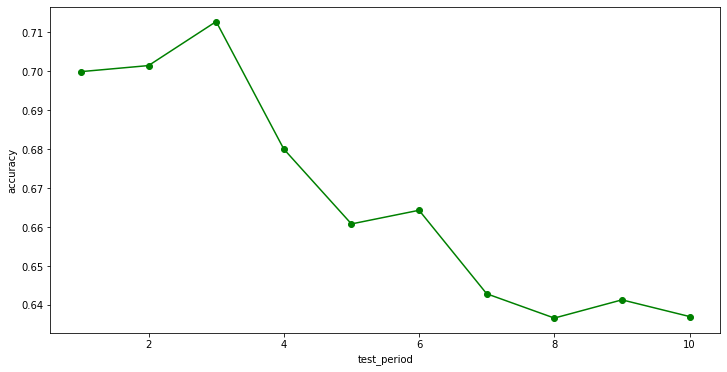

In [170]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_accuracy'], "o-", color='green')

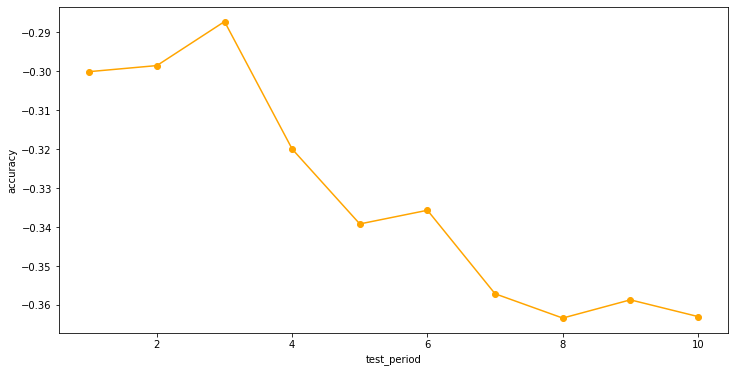

In [172]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_mse'], "o-", color='orange')

## XGBRegressor

In [132]:
regr = xgb.XGBRegressor(n_jobs=3)
metric_accuracy = make_scorer(my_accuracy)
cv_res = cross_validate(regr, X_train, y_train, scoring = {'accuracy': metric_accuracy,
                                                          'mse': 'neg_mean_squared_error'}, return_train_score=True, cv=10)

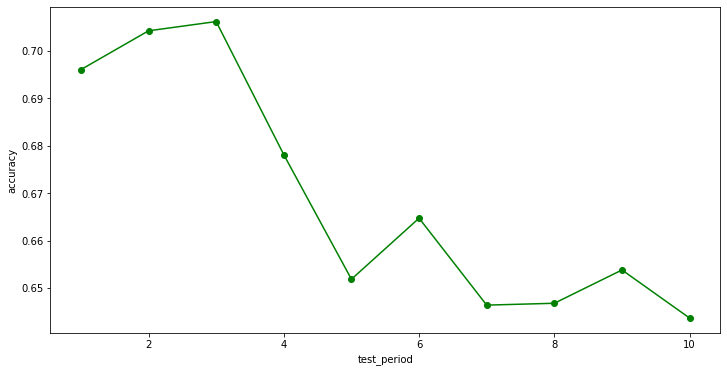

In [102]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_accuracy'], "o-", color='green')

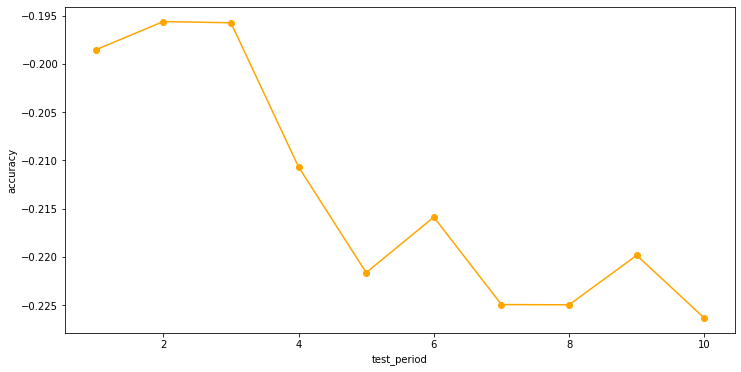

In [133]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], cv_res['test_mse'], "o-", color='orange')

## XGBClassifier

In [163]:
metric_accuracy = make_scorer(my_accuracy)
grid_params = {
    'learning_rate': [0.01, 0.02], 
    'max_depth': [1, 2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8],
    'n_estimators': [150, 250],
    'eval_metric': ['logloss']
}

scoring = {'accuracy': metric_accuracy, 'mse': 'neg_mean_squared_error'}
cv = TimeSeriesSplit(n_splits=10)
gs_cl = GridSearchCV(xgb.XGBClassifier(n_jobs=3), grid_params, cv=cv, scoring=scoring, return_train_score=True, refit=False)
gs_cl.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'colsample_bytree': [0.8], 'eval_metric': ['logloss'],
                         'learning_rate': [0.01, 0.02], 'max_depth'

In [164]:
res_accuracy_cl = []
res_mse_cl = []
for x in range(10):
    res_accuracy_cl.append(gs_cl.cv_results_['split{0}_test_accuracy'.format(x)].mean())
    res_mse_cl.append(gs_cl.cv_results_['split{0}_test_mse'.format(x)].mean())

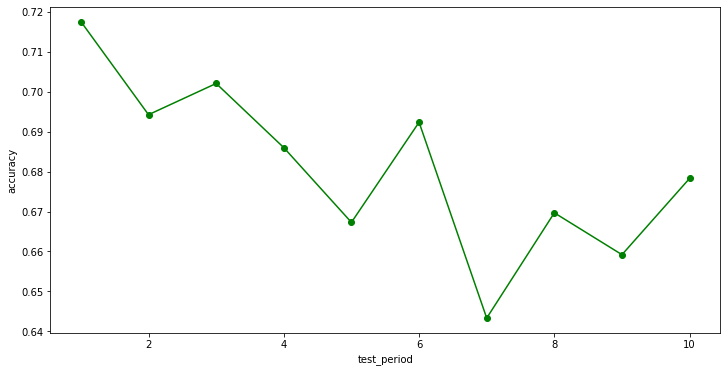

In [165]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], res_accuracy_cl, "o-", color='green')

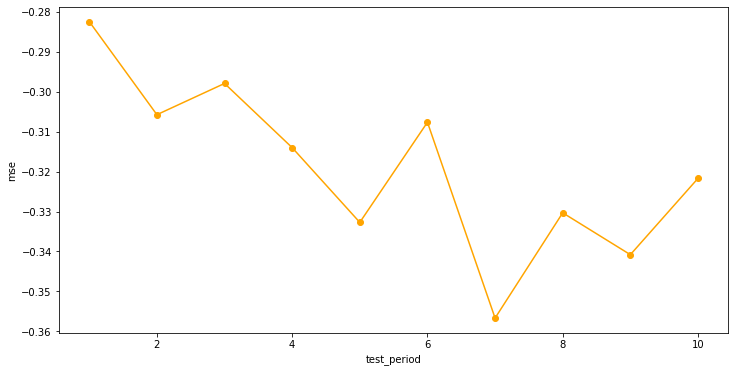

In [166]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], res_mse_cl, "o-", color='orange')

## XGBRegressor

In [150]:
metric_accuracy = make_scorer(my_accuracy)
grid_params = {
    'learning_rate': [0.01, 0.02], 
    'max_depth': [1, 2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.8],
    'n_estimators': [150, 250]
}

scoring = {'accuracy': metric_accuracy, 'mse': 'neg_mean_squared_error'}
cv = TimeSeriesSplit(n_splits=10)
gs_reg = GridSearchCV(xgb.XGBRegressor(n_jobs=3), grid_params, cv=cv, scoring=scoring, return_train_score=True, refit=False)
gs_reg.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'colsample_bytree': [0.8],
                         'learning_r

In [155]:
res_accuracy = []
res_mse = []
for x in range(10):
    res_accuracy.append(gs_reg.cv_results_['split{0}_test_accuracy'.format(x)].mean())
    res_mse.append(gs_reg.cv_results_['split{0}_test_mse'.format(x)].mean())

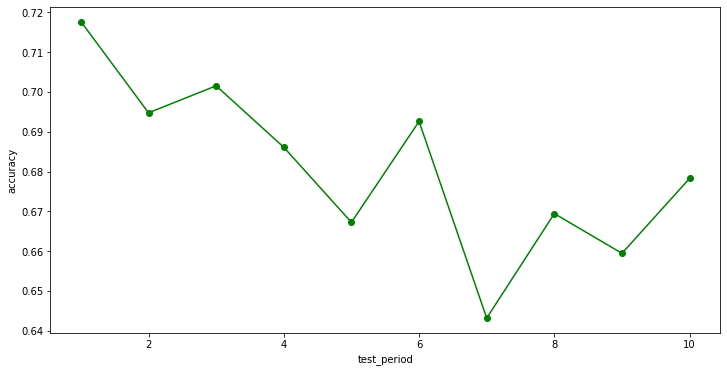

In [158]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("accuracy")
plt.plot([x for x in range(1, 11)], res_accuracy, "o-", color='green')

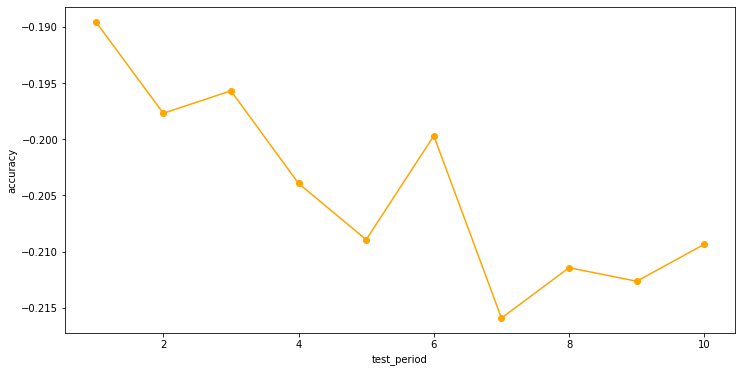

In [160]:
plt.figure(figsize=(12,6))
plt.xlabel("test_period")
plt.ylabel("mse")
plt.plot([x for x in range(1, 11)], res_mse, "o-", color='orange')